In [7]:
import os, sys, math, pickle, time
from zmqRemoteApi import RemoteAPIClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randint as ri
from random import uniform as ru

from keras.models import Sequential
from keras.layers import Dense
from keras.losses import Huber
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

### Funciones

In [8]:
#Function to split the training data into X,y datasets
def load_dataset(scene_in = "modular02a"):
    # Defining usefull variables
    path = os.getcwd() + "\\training_data\\2023_14_11"
    file_list = os.listdir(path)
    scene_files_list = [item for item in file_list if scene_in in item and "pkl" in item]


    file = open(path + "\\" + scene_files_list[0], "rb")
    training_data = pickle.load(file)
    training_df = pd.DataFrame(training_data)

    #List to store the name for every joint data column
    increments_columns = []
    prev_j_positions_columns = []
    post_j_positions_columns = []

    #Creates the name for every column
    num_joints = len(training_data[-1]["increments"])
    for joint_n in range(num_joints):
        #List to split inputs per joint
        joint_inc_col_name = "increments_" + str(joint_n)
        increments_columns.append(joint_inc_col_name)

        prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
        prev_j_positions_columns.append(prev_joint_pos_col_name)

        #List to split outputs per joint
        post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
        post_j_positions_columns.append(post_joint_pos_col_name)


    #Input columns per joint
    increments_df = pd.DataFrame(training_df['increments'].to_list())
    increments_df.columns = increments_columns


    prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
    prev_j_positions_df.columns = prev_j_positions_columns


    #Builds the X dataframe
    X_df = pd.concat([increments_df, prev_j_positions_df, 
                    training_df["prev_pos_x"], training_df["prev_pos_y"], training_df["prev_pos_z"]], 
                    axis="columns")


    #Output columns per joint
    post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
    post_j_positions_df.columns = post_j_positions_columns


    #Builds the y dataframe
    y_df = pd.concat([post_j_positions_df, 
                    training_df["post_pos_x"], training_df["post_pos_y"], training_df["post_pos_z"]], 
                    axis="columns")

    return(X_df,y_df)

In [9]:
def adapt_X_y(X_a,y_a):
    X_a_cols = ['current_state_x', 'current_state_y', 'current_state_z', 'joint0_current_state_rad', 'joint1_current_state_rad', 'joint0_actions_rad', 'joint1_actions_rad']

    X_a = pd.concat([X_a["prev_pos_x"], X_a["prev_pos_y"] , X_a["prev_pos_z"],
                X_a["prev_j_positions_0"], X_a["prev_j_positions_1"],
                X_a["increments_0"], X_a["increments_1"]], 
                        axis="columns")

    X_a.columns = X_a_cols

    y_a_cols = ['future_state_x', 'future_state_y', 'future_state_z', 'joint0_future_state_rad', 'joint1_future_state_rad']

    y_a = pd.concat([y_a["post_pos_x"], y_a["post_pos_y"] , y_a["post_pos_z"],
                y_a["post_j_positions_0"], y_a["post_j_positions_1"]], 
                        axis="columns")
    y_a.columns = y_a_cols
    return X_a, y_a

In [10]:
def plot_history(history, loss):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel(f'{loss} Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  #plt.ylim([0,0.1])
  plt.legend()
  plt.show()

In [11]:
def plot_pred_vs_test(test, pred):
    columns = test.columns.tolist()
    max_list = []
    min_list = []
    mse_list = []
    perc_mse_list = []
    for column_num in range(len(columns)):
        plt.figure()
        plt.scatter(test.iloc[:,column_num], pred.iloc[:,column_num], s=1)

        #Getting important values
        minim = min(test.iloc[:,column_num])
        min_list.append(minim)
        maxim = max(test.iloc[:,column_num])
        max_list.append(maxim)
        mse = mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse_list.append(round(mse,6))
        rang = (maxim-minim)
        perc = mse/rang *100
        perc_mse_list.append(round(perc,6))
        title = columns[column_num] + " - mse: " + str(round(mse,6))
        plt.title(title)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        # Para tener una linea recta con la cual comparar los valores y que no altere
        # los limites de la figura se grafican los valores reales con ellos mismos
        plt.plot(test.iloc[:,column_num],test.iloc[:,column_num])
        plt.grid()
    data = {"Perception": columns, "Max.": max_list, "Min.": min_list, "Mse": mse_list, "Mse perc.": perc_mse_list}
    data_df = pd.DataFrame(data)
    return(data_df)

### Modular 02

In [12]:
scene = "modular02_"
X, y =load_dataset(scene)
X, y = adapt_X_y(X,y)

In [13]:
maxim = max(y.iloc[:,-1])
maxim

1.5707972049713135

In [14]:
minim = min(y.iloc[:,-1])
minim

-1.5707972049713135

In [15]:
# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

X_train.shape, y_train.shape

((28000, 7), (28000, 5))

### Datos de entrenamiento

In [24]:
scene = "modular02_"
path = os.getcwd() + "\\training_data\\2023_14_11"
file_list = os.listdir(path)
scene_files_list = [item for item in file_list if scene in item and "pkl" in item]
file = open(path + "\\" + scene_files_list[0], "rb")
training_data = pickle.load(file)
training_df = pd.DataFrame(training_data)

['current_state_x', 'current_state_y', 'current_state_z', 'joint0_current_state_rad', 'joint1_current_state_rad', 'joint0_actions_rad', 'joint1_actions_rad']


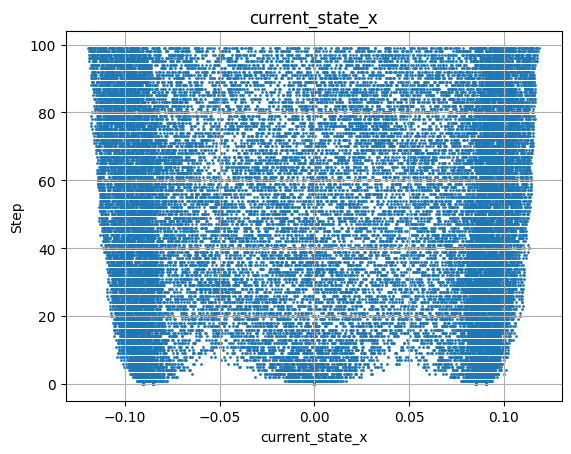

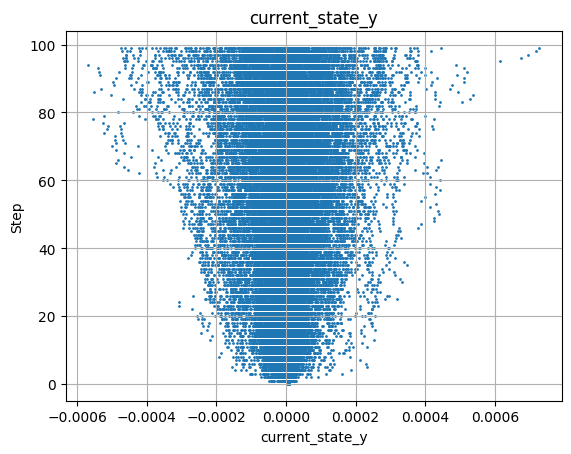

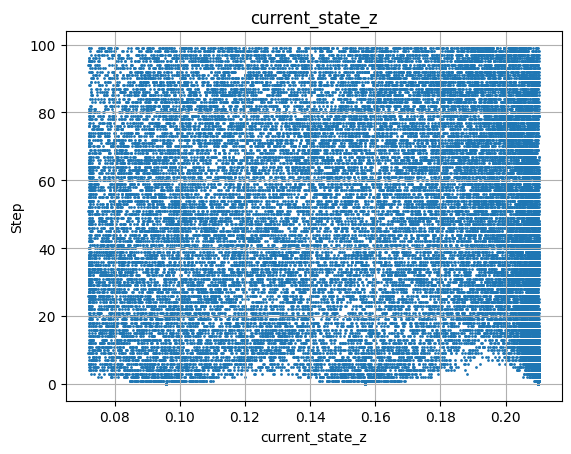

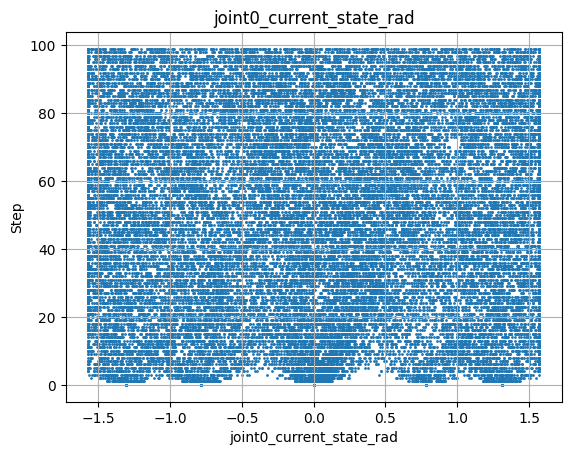

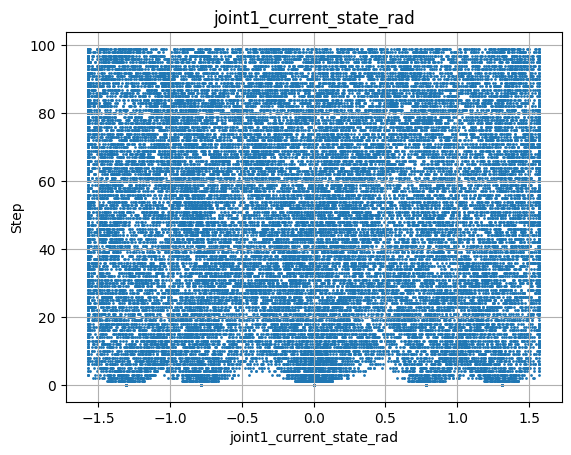

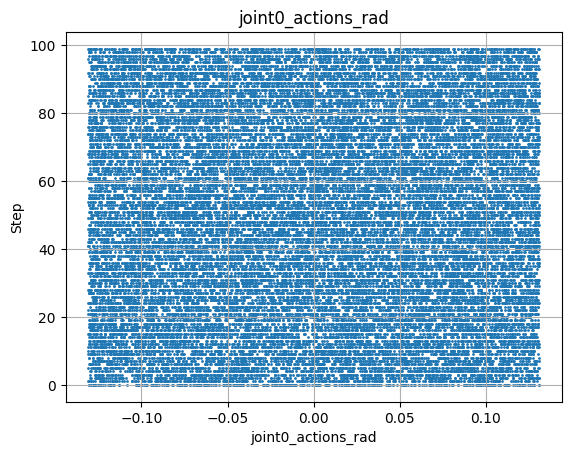

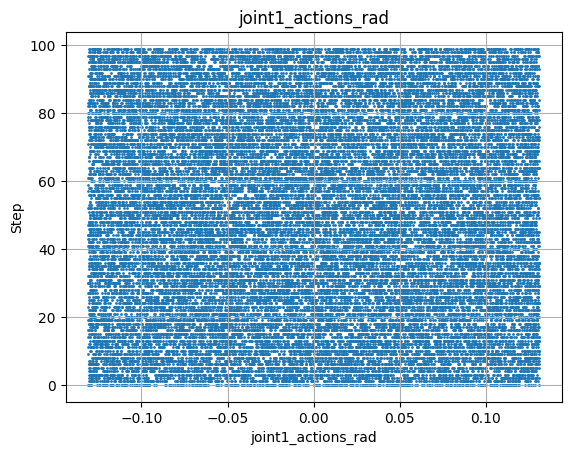

In [25]:
columns = X_train.columns.tolist()
print(columns)
for col in range(len(columns)):
    plt.figure()
    plt.scatter(X.iloc[:,col],training_df.iloc[:,1], s=1)
    plt.title(columns[col])
    plt.ylabel('Step')
    plt.xlabel(columns[col])
    plt.grid()

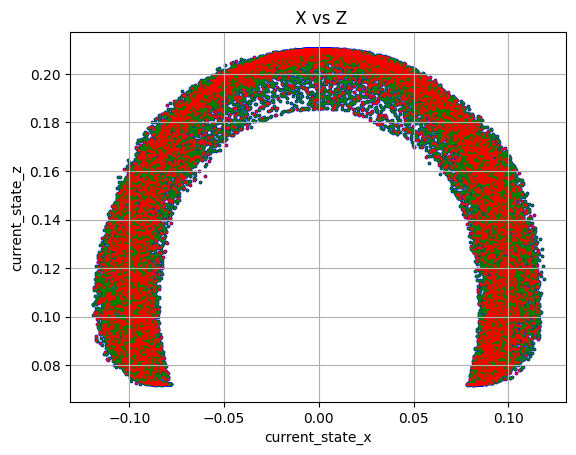

In [26]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(X.iloc[:,-7],X.iloc[:,-5], s=5, color='blue')
plt.scatter(X_train.iloc[:,-7],X_train.iloc[:,-5], s=1, color='green', label='Entrenamiento')
plt.scatter(X_test.iloc[:,-7],X_test.iloc[:,-5], s=1, color='red', label='Validacion')
plt.title(" X vs Z")
plt.ylabel(columns[-5])
plt.xlabel(columns[-7])
plt.legend()
plt.grid()

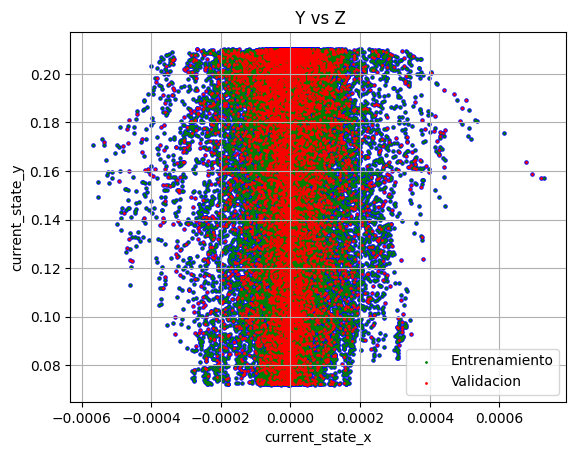

In [28]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(X.iloc[:,-6],X.iloc[:,-5], s=5, color='blue')
plt.scatter(X_train.iloc[:,-6],X_train.iloc[:,-5], s=1, color='green', label='Entrenamiento')
plt.scatter(X_test.iloc[:,-6],X_test.iloc[:,-5], s=1, color='red', label='Validacion')
plt.title(" Y vs Z")
plt.ylabel(columns[-6])
plt.xlabel(columns[-7])
plt.legend()
plt.grid()

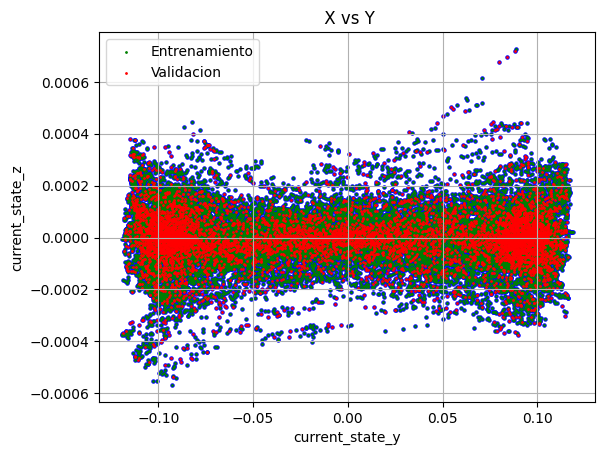

In [29]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(X.iloc[:,-7],X.iloc[:,-6], s=5, color='blue')
plt.scatter(X_train.iloc[:,-7],X_train.iloc[:,-6], s=1, color='green', label='Entrenamiento')
plt.scatter(X_test.iloc[:,-7],X_test.iloc[:,-6], s=1, color='red', label='Validacion')
plt.title(" X vs Y")
plt.ylabel(columns[-5])
plt.xlabel(columns[-6])
plt.legend()
plt.grid()

Se grafica para cada posicion del joint las acciones

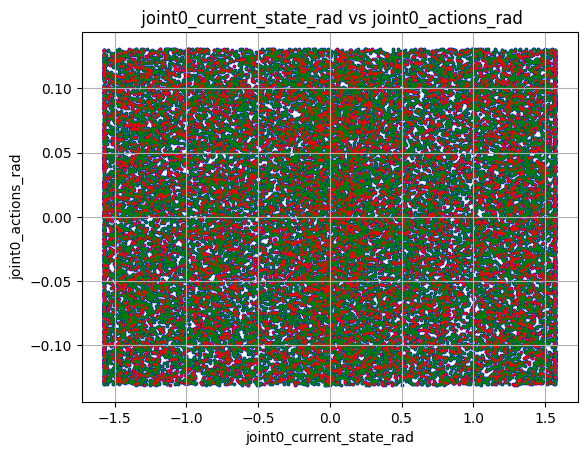

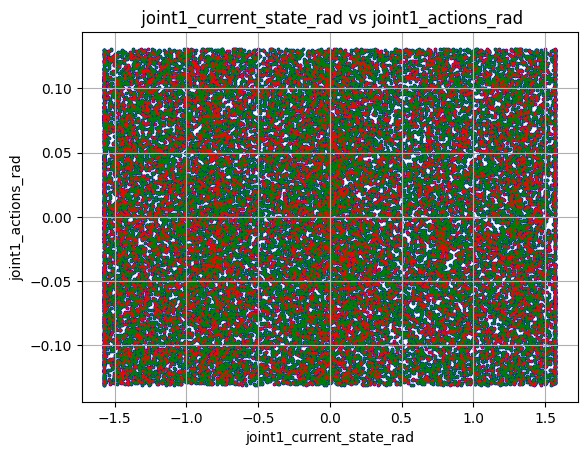

In [27]:
columns = X_train.columns.tolist()
joints_col = []
for col in columns:
    if "joint" in col:
        joints_col.append(col)
joints_col
joints_n = len(joints_col)//2
for joint in range(joints_n):
    plt.figure()
    state_col = 3 + joint
    act_col = 3 + joint + joints_n
    plt.scatter(X.iloc[:,state_col],X.iloc[:,act_col], s=3, color='blue')
    plt.scatter(X_train.iloc[:,state_col],X_train.iloc[:,act_col], s=5, color='green', label='Entrenamiento')
    plt.scatter(X_test.iloc[:,state_col],X_test.iloc[:,act_col], s=1, color='red', label='Validacion')
    plt.title(f" {columns[state_col]} vs {columns[act_col]}")
    plt.ylabel(columns[act_col])
    plt.xlabel(columns[state_col])
    plt.legend()
    plt.grid()